In [1]:
%matplotlib notebook

from utils import *
import sys
sys.path.append("/home/armstrong/crisPy")
from instrument import CRISP
import torch
import matplotlib.pyplot as plt

from IPython.core.display import display,HTML
display(HTML("<style>.container{ width:100% !important;}</style>"))
model_pth = "Radynversion_1.0.0.pth.tar"
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
model,z,ha_wvls,ca_wvls = create_model(model_pth,dev)

=> loading checkpoint 'Radynversion_1.0.0.pth.tar'
Node Inv0 has following input dimensions:
	 Output #0 of node Input (0-pad extra channels): (384,)

Node Permute0 has following input dimensions:
	 Output #0 of node Inv0: (384,)

Node Inv1 has following input dimensions:
	 Output #0 of node Permute0: (384,)

Node Permute1 has following input dimensions:
	 Output #0 of node Inv1: (384,)

Node Inv2 has following input dimensions:
	 Output #0 of node Permute1: (384,)

Node Permute2 has following input dimensions:
	 Output #0 of node Inv2: (384,)

Node Inv3 has following input dimensions:
	 Output #0 of node Permute2: (384,)

Node Permute3 has following input dimensions:
	 Output #0 of node Inv3: (384,)

Node Inv4 has following input dimensions:
	 Output #0 of node Permute3: (384,)

Node Output has following input dimensions:
	 Output #0 of node Inv4: (384,)

=> loaded checkpoint 'Radynversion_1.0.0.pth.tar' (total number of epochs trained for 11400)


In [3]:
ca_folder = "/local1/scratch/armstrong/2014-09-06/ca8542/"
ca_files = obs_files(ca_folder)
ha_folder = "/local1/scratch/armstrong/2014-09-06/Halpha/"
ha_files = obs_files(ha_folder)

ha_central_idx = 7
ca_central_idx = 12
ha_hw = 1.4
ca_hw = 1.0 #1.0 because RADYN has a 1A half-width for calcium

In [4]:
idx = 460
roi_x = (300,1001)
roi_y = (600,1001)
fine_roi = (573,677)
crisp = CRISP(ca_file=ca_files[idx],ha_file=ha_files[idx],rotate=False)

<IPython.core.display.Javascript object>


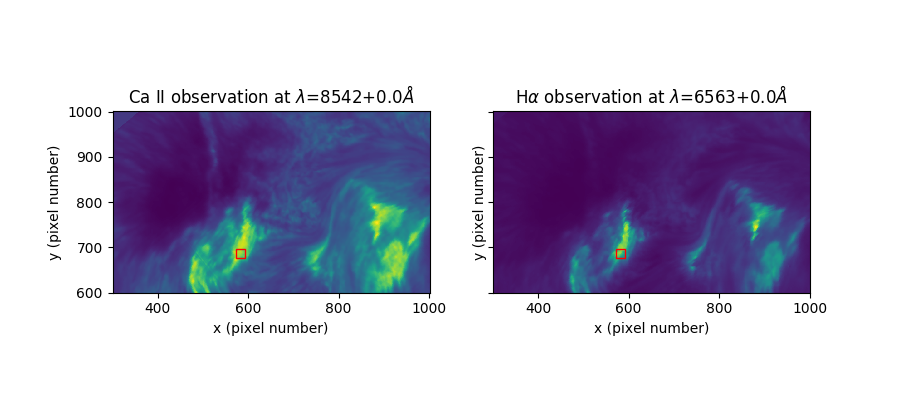

In [5]:
crisp.map_3(ca_ind=ca_central_idx,ha_ind=ha_central_idx,draw_rect=True,rect=fine_roi,rect_x=20,rect_y=20,crop=True,crop_x=roi_x,crop_y=roi_y)

<IPython.core.display.Javascript object>


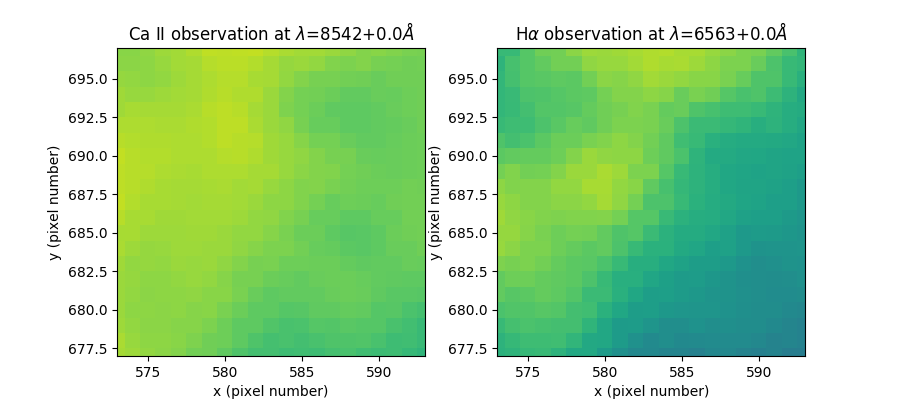

In [6]:
crisp.map_3(ca_ind=ca_central_idx,ha_ind=ha_central_idx,crop=True,crop_x=(fine_roi[0],fine_roi[0]+20),crop_y=(fine_roi[1],fine_roi[1]+20))

In [7]:
point_1 = (579,687)
point_2 = (593,677)

In [8]:
ca_1 = crisp.intensity_vector(point_1)
ha_1 = crisp.intensity_vector(point_1,line="ha")
ca_2 = crisp.intensity_vector(point_2)
ha_2 = crisp.intensity_vector(point_2,line="ha")
ca_centre_wvl = crisp.header.ca["TWAVE1"]
ca_wvls = crisp.data.ca_wvls
ha_centre_wvl = crisp.header.ha["TWAVE1"]
ha_wvls = crisp.data.ha_wvls

In [9]:
new_ca_1 = interp_to_radyn_grid(ca_1,ca_centre_wvl,ca_hw,ca_wvls)
new_ha_1 = interp_to_radyn_grid(ha_1,ha_centre_wvl,ha_hw,ha_wvls)
new_ca_2 = interp_to_radyn_grid(ca_2,ca_centre_wvl,ca_hw,ca_wvls)
new_ha_2 = interp_to_radyn_grid(ha_2,ha_centre_wvl,ha_hw,ha_wvls)

In [10]:
new_ca_1, new_ha_1 = normalise(new_ca_1,new_ha_1)
new_ca_2, new_ha_2 = normalise(new_ca_2,new_ha_2)

<IPython.core.display.Javascript object>


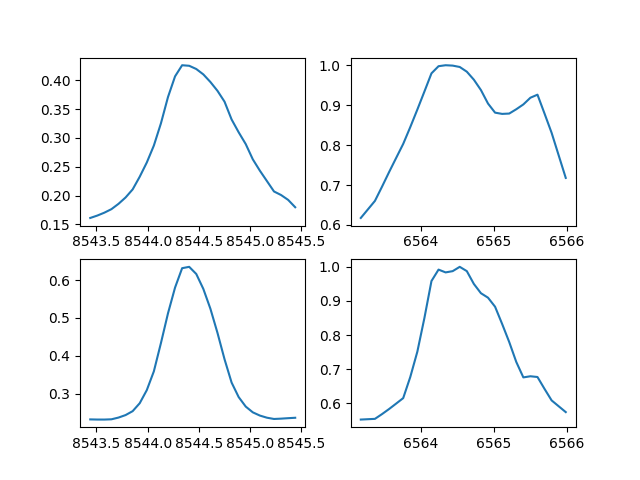

In [11]:
fig, ax = plt.subplots(2,2)
ax[0,0].plot(new_ca_1[0],new_ca_1[1])
ax[0,1].plot(new_ha_1[0],new_ha_1[1])
ax[1,0].plot(new_ca_2[0],new_ca_2[1])
ax[1,1].plot(new_ha_2[0],new_ha_2[1])

In [12]:
%%time
results = inversion(model,dev,new_ca_1,new_ha_1,batch_size=100)

CPU times: user 20.6 ms, sys: 8.82 ms, total: 29.4 ms
Wall time: 28.1 ms


<IPython.core.display.Javascript object>


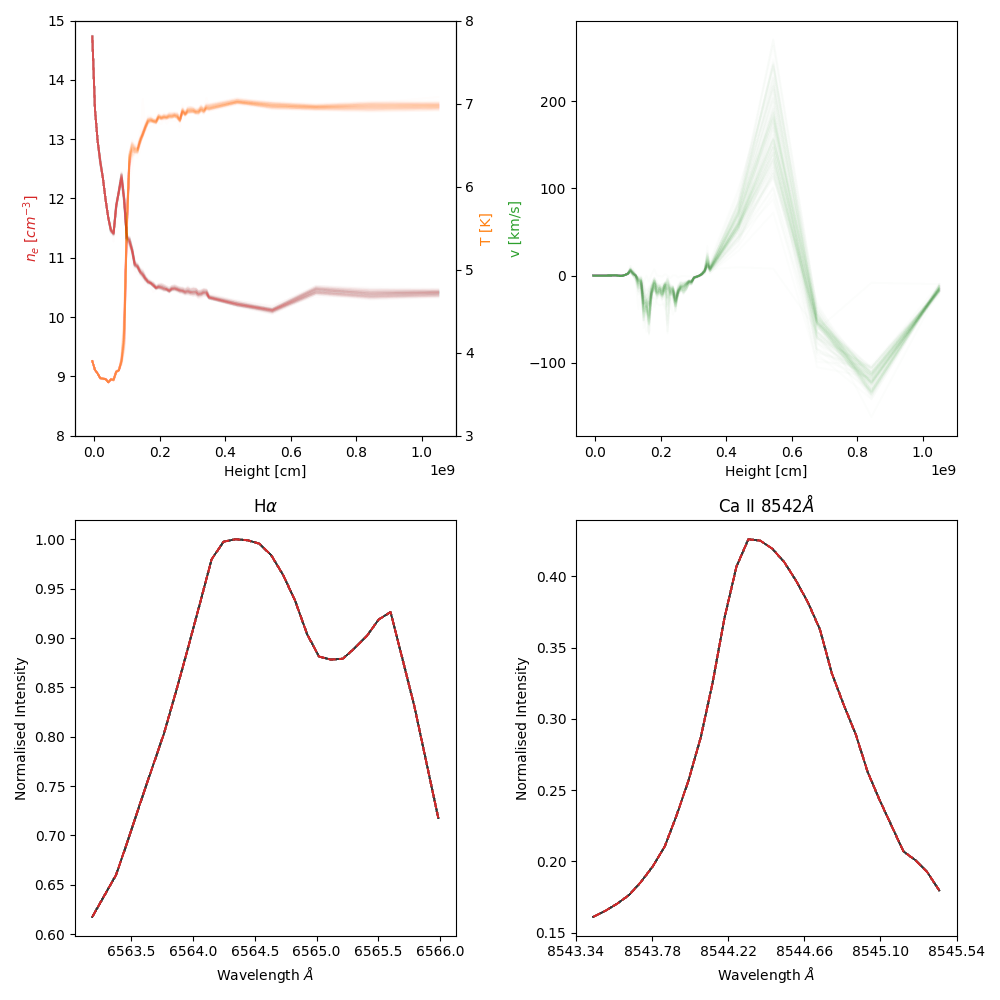

In [13]:
inversion_plots(results,100,z,new_ca_1,new_ha_1)

In [14]:
results_2 = inversion(model,dev,new_ca_2,new_ha_2,100)

<IPython.core.display.Javascript object>


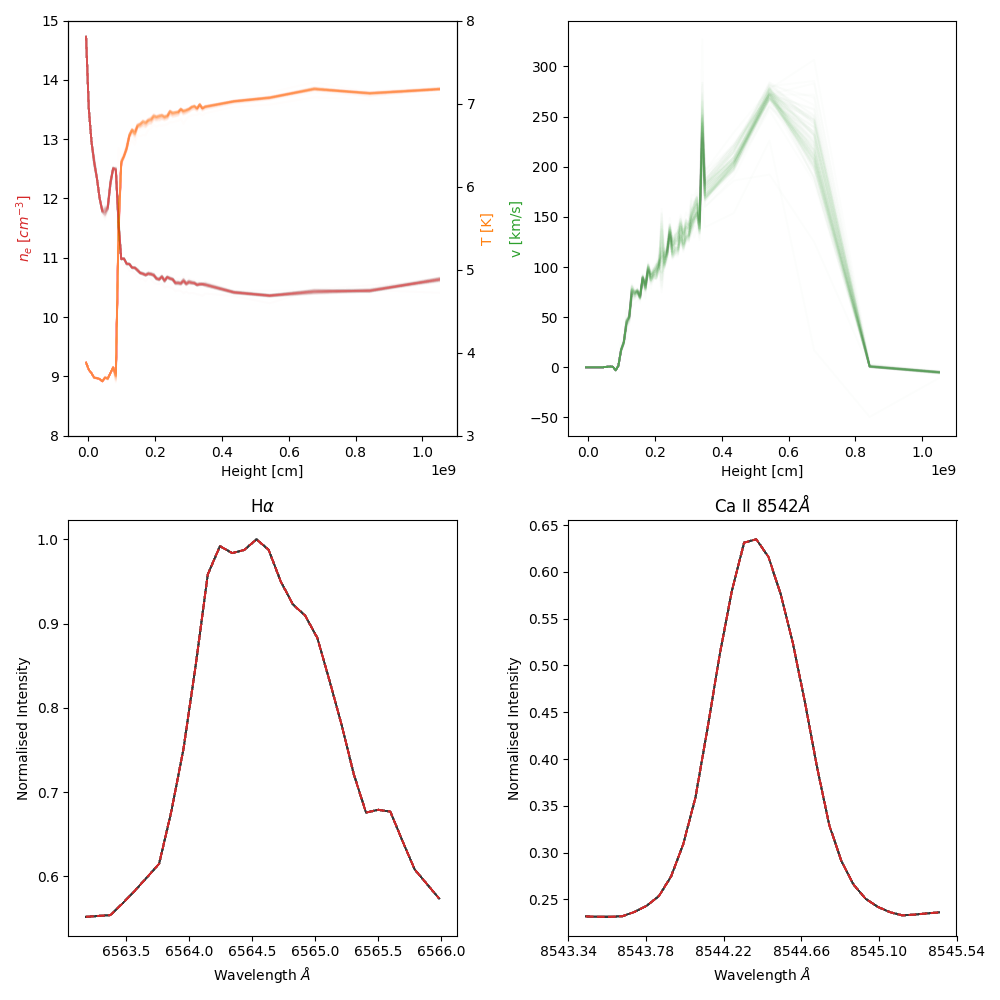

In [15]:
inversion_plots(results_2,100,z,new_ca_2,new_ha_2)